# Homework 6

Let us analyze the trajectory of a planet, or any other asteroid, as it travels around the sun. Let us model its current state in terms of its position $X(T)$ and velocity $V(t)$. We assume the sun is fixed at the center of coordinates $x = 0$.

By definition, velocity is the derivative of the position: $X'(t) = V(t)$. Newton's law of gravity says that the planet will be attracted toward the sun with a force inverse proportional to the square of its distance. That means
$$ V'(t) = -c \frac{X(t)}{|X(t)|^2}.$$

Our job today is to approximate the solution of this ODE. The constant $c$ depends on the mass of the planet, the mass of the sun, the units of time, the universal gravitational constant, etc... For us $c=1$ :)

# Github Link:
A link to my Github is here (https://github.com/dleksanov/math212-homeworks/blob/main/hw6.ipynb), so that it is possible to see the movies.

Note also that this is literally a second order ODE: $X'' = -X / |X|^3$. We rewrite it as a first order system in order to apply our standard methods.
$$ \begin{cases} X' = V, \\ V' = -X / |X|^3. \end{cases}$$

We will write generic code to solve systems of ODEs. Then, we will apply it to the equation above.

## Euler method

Let us write a generic function that computes the solution of an ODE by Euler's method. It takes an initial point $x_0$ which is supposed to belong to $\mathbb R^d$. It applies a given function $f : \mathbb R^d \to \mathbb R^d$. Let us assume, for simplicity, that the function $f$ does not depend on time.

In [1]:
function euler_method(x0::Array{<:Real,1}, f::Function, h::Real)
    x = x0 + h*f(x0)
    return x
end

euler_method (generic function with 1 method)

In order to approximate the orbit of a planet, let us define a function $f(x,v) = (v,-x/|x|^3)$ as above.

In [2]:
function norm_squared(x::Array{<:Real,1})
    return reduce(+,map(y->y^2,x))
end

function newton_gravity_law(u::Array{<:Real,1})    
    # Here u = (x,v). The dimension is really half of the length of u
    d = div(length(u),2)
    dx = u[d+1:2d]
    x = u[1:d]
    dv = -x / norm_squared(x)^(3/2)
    return vcat(dx,dv)
end  
    

newton_gravity_law (generic function with 1 method)

Here is a function to draw the result of different iteration schemes.

┌ Info: Saved animation to 
│   fn = /Users/dimitriyl/fall2021/math212/tmp.gif
└ @ Plots /Users/dimitriyl/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/Users/dimitriyl/fall2021/math212/tmp.gif")
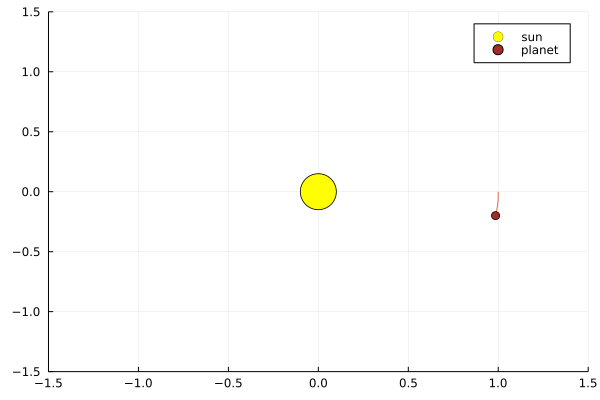

In [3]:
using Plots

function draw_planet_orbit(x0::Array{<:Real,1}, v0::Array{<:Real,1}, h::Real, time::Real, iteration::Function)
    #  draw the sun first
    scatter((0.,0.),color=:yellow, markersize=20, xlims=(-1.5,1.5), ylims=(-1.5,1.5), label="sun")
    
    iterations = Int(round(time/h))
    x_list = [x0[1]]
    y_list = [x0[2]]
    x = x0
    v = v0
    for i in 1:iterations
        u = iteration(x,v,h)
        push!(x_list,u[1])
        push!(y_list,u[2])
        x = u[1:2]
        v = u[3:4]
    end
    plot!(x_list,y_list, label="")
    scatter!([x[1]],[x[2]],color=:brown, markersize=5, label="planet")
end

iteration_Euler(x,v,h) = euler_method(vcat(x,v), newton_gravity_law, h)

@gif for i in 1:600
    # this is admittedly inefficient. I recompute the solution from the beginning in each frame! Oh well...
    draw_planet_orbit([1.,0.],[0.,-1.], 0.05, 0.2*i, iteration_Euler)
end

This first computation should not be working so well. Planets orbit around the sun on an elliptical cycle. I do not see it with Euler's method. The computation is more accurate for small values of $h$, and worse for large values of $h$. Thus, the following movie should look closer to reality, but it will take longer to compute.

┌ Info: Saved animation to 
│   fn = /Users/dimitriyl/fall2021/math212/tmp.gif
└ @ Plots /Users/dimitriyl/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/Users/dimitriyl/fall2021/math212/tmp.gif")
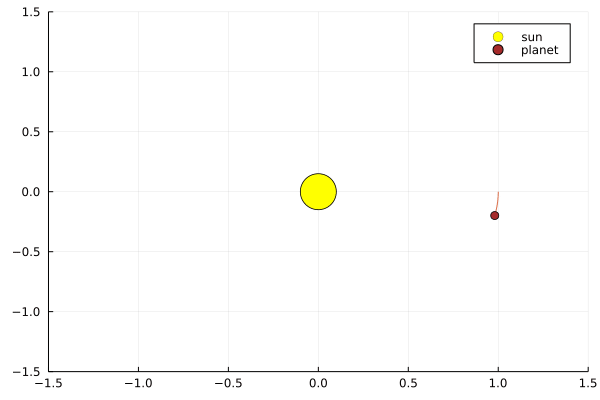

In [4]:
@gif for i in 1:600
    draw_planet_orbit([1.,0.],[0.,-1.], 0.005, 0.2*i, iteration_Euler)
end

Let me propose a small modification of Euler method that would make the picture look more realistic. The movement of the plant should conserve energy. That is, the sum of the potential plus kinetic energy should be constant in time:
$$ E = -\frac 1 {|X|} + \frac{|V|^2}2. $$
So, how about we force it to be? At every step of Euler iteration, let us adjust the value of $|X|$ so that the energy remains constant. It is admittedly artificial. I do not have any justification why adjusting $|X|$ would be a better idea than adjusting $|V|$. It would be worth trying different alternatives.

┌ Info: Saved animation to 
│   fn = /Users/dimitriyl/fall2021/math212/tmp.gif
└ @ Plots /Users/dimitriyl/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/Users/dimitriyl/fall2021/math212/tmp.gif")
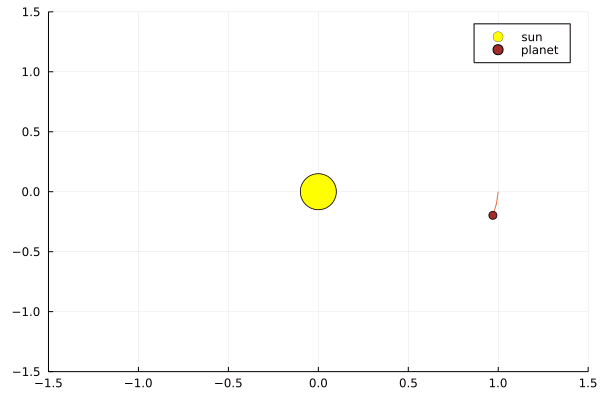

In [5]:
function iteration_Euler_constant_energy(x,v,h)
    energy = -1/sqrt(norm_squared(x)) + norm_squared(v)/2
    u = euler_method(vcat(x,v), newton_gravity_law, h)
    new_energy = -1/sqrt(norm_squared(u[1:2])) + norm_squared(u[3:4])/2
    diff = (energy-new_energy)*sqrt(norm_squared(u[1:2]))
    u[1:2] = (1-diff)^(-1)*u[1:2]
    return u
end
    

@gif for i in 1:600
    draw_planet_orbit([1.,0.],[0.,-1.], 0.1, 0.2*i, iteration_Euler_constant_energy)
end

The orbit does not look bad at all in my computer, even though we used a coarser step size $h=0.1$. The logic is that the conservation of energy is one of the key features of the ODE that we are simulating. By making sure that our numerical computation also satisfies conservation of energy, then the result that we find will look more realistic. I am not sure how accurate this method really is.

Ok. I've done enough. You are going to have to write the code below.

## Other methods for solving ODEs

Let us now implement the *higher order obvious* method (should we call it the *power series method*?), the modified Euler, and the RK4.

You may take a look at the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods#Classic_fourth-order_method) for Runge Kutta methods. The ones I am asking you to implement are listed there as "forward Euler", "Heun's method", and "Classic fourth-order method".

None of you seemed to be bothered by the fact that we needed to compute the derivative of a function in order to implement the higher order method using power series. So, I will write the function and you are only required to write the derivative of the newton gravity law.

In [6]:
function higher_order_obvious(x0::Array{<:Real,1}, f::Function, fx::Function, h::Real)
# Here, fx is the derivative of f. fx returns a d x d matrix.   
# It must be provided explicitly for this method to work.
    x = x0 + h*f(x0) + h^2/2 * fx(x0) * f(x0)
    return x
end

function derivative_of_newton_gravity_law(u::Array{<:Real,1})    
    # Here u = (x,v). The dimension is really half of the length of u
    d = div(length(u),2)
    x = u[1:d]
    
    ret_mat = zeros(4, 4)

    for i in 1:d
       for j in 1:d
            if i==j
                ret_mat[i, j+d] = 1
                ret_mat[i+d, j] = (3*(x[i])^2 - norm_squared(x)) / norm_squared(x)^(5/2)
            else
                ret_mat[i+d, j] = (3*x[i]*x[j]) / norm_squared(x)^(5/2)
            end
       end
    end
    
    return ret_mat
end  

derivative_of_newton_gravity_law (generic function with 1 method)

If your code is correct, the code below will generate a cute movie.

┌ Info: Saved animation to 
│   fn = /Users/dimitriyl/fall2021/math212/tmp.gif
└ @ Plots /Users/dimitriyl/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/Users/dimitriyl/fall2021/math212/tmp.gif")
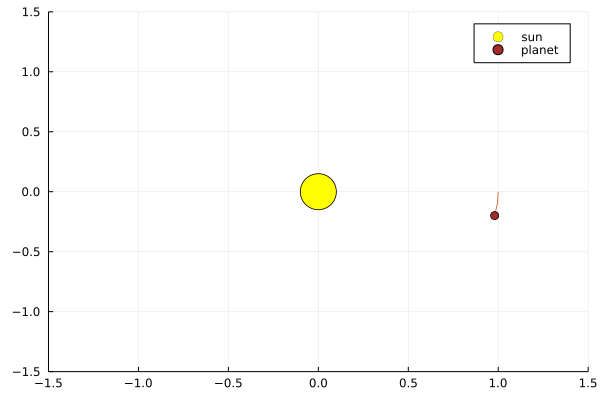

In [7]:
iteration_higher_order(x,v,h) = higher_order_obvious(vcat(x,v), newton_gravity_law, derivative_of_newton_gravity_law, h)

@gif for i in 1:600
    draw_planet_orbit([1.,0.],[0.,-1.], 0.1, 0.2*i, iteration_higher_order)
end

It should be a rather accurate computation already.

Let us implement the other two methods now.

In [8]:
function modified_euler(x0::Array{<:Real,1}, f::Function, h::Real)
    d = div(length(x0),2)
    y0 = x0[d+1:2d]
    
    k1 = f(x0)
    
    x1 = x0 + h*k1
    k2 = f(x1)
    
    x = x0 + (1/2)*h*k1 + (1/2)*h*k2
    return x
end

function RK4(x0::Array{<:Real,1}, f::Function, h::Real)
    d = div(length(x0),2)
    y0 = x0[d+1:2d]
    
    k1 = f(x0)
    
    x1 = x0 + h*(1/2)*k1
    k2 = f(x1)
    
    x2 = x0 + h*(1/2)*k2
    k3 = f(x2)
    
    x3 = x0 + h*k3
    k4 = f(x3)
    
    x = x0 + (1/6)*h*k1 + (1/3)*h*k2 + (1/3)*h*k3 + (1/6)*h*k4
    return x
end

RK4 (generic function with 1 method)

And we test them...

┌ Info: Saved animation to 
│   fn = /Users/dimitriyl/fall2021/math212/tmp.gif
└ @ Plots /Users/dimitriyl/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/Users/dimitriyl/fall2021/math212/tmp.gif")
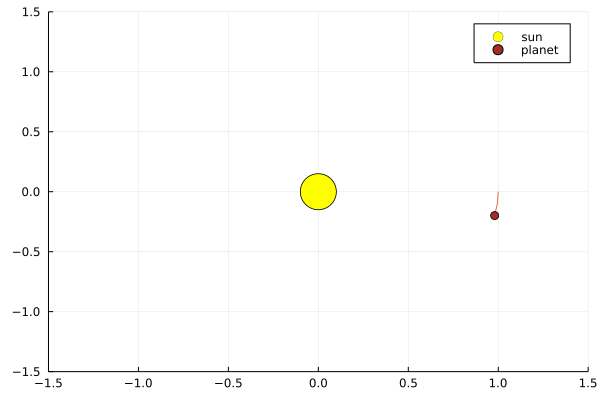

In [9]:
iteration_modified_Euler(x,v,h) = modified_euler(vcat(x,v), newton_gravity_law, h)

@gif for i in 1:600
    draw_planet_orbit([1.,0.],[0.,-1.], 0.1, 0.2*i, iteration_modified_Euler)
end

┌ Info: Saved animation to 
│   fn = /Users/dimitriyl/fall2021/math212/tmp.gif
└ @ Plots /Users/dimitriyl/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/Users/dimitriyl/fall2021/math212/tmp.gif")
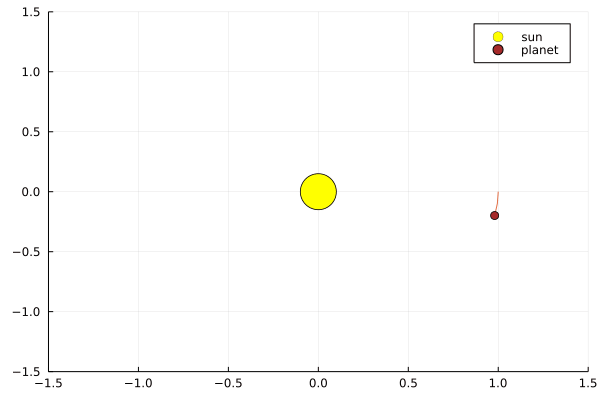

In [10]:
iteration_RK4(x,v,h) = RK4(vcat(x,v), newton_gravity_law, h)

@gif for i in 1:600
    draw_planet_orbit([1.,0.],[0.,-1.], 0.1, 0.2*i, iteration_RK4)
end

Using the fourth order Runge-Kutta method gives me a practically perfect solution.

Interestingly, the orbits computed by all methods other than the vanilla Euler seem to be quite precise. The trajectories are not as accurate as they seem. The code below draws the trajectory of three different planets computed with three different methods: RK4, Euler with fixed energy, and modified Euler. If the computations were perfect, the three planets should stay at the same position along their trajectory. As you will see, they depart from each other quite a lot.

In [11]:
function draw_many_planets_orbit(x0::Array{<:Real,1}, v0::Array{<:Real,1}, h::Real, time::Real, iteration::Function...)
    #  draw the sun first
    scatter((0.,0.),color=:yellow, markersize=20, xlims=(-1.5,1.5), ylims=(-1.5,1.5), label="sun")
    
    iterations = Int(round(time/h))
    counter = 1
    for planet in iteration
        x_list = [x0[1]]
        y_list = [x0[2]]
        x = x0
        v = v0
        for i in 1:iterations
            u = planet(x,v,h)
            push!(x_list,u[1])
            push!(y_list,u[2])
            x = u[1:2]
            v = u[3:4]
        end
        plot!(x_list,y_list, label="")
        scatter!([x[1]],[x[2]], markersize=5, label="planet "*string(counter))
        counter += 1
    end
end


draw_many_planets_orbit (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /Users/dimitriyl/fall2021/math212/tmp.gif
└ @ Plots /Users/dimitriyl/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/Users/dimitriyl/fall2021/math212/tmp.gif")
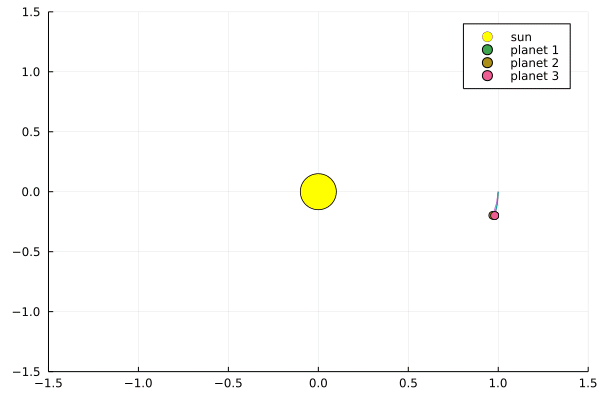

In [12]:
@gif for i in 1:600
    draw_many_planets_orbit([1.,0.],[0.,-1.], 0.1, 0.2*i, iteration_RK4, iteration_Euler_constant_energy, iteration_modified_Euler)
end

## Other tests.

How about we solve a few other ODEs for fun. We have generic code written above. Let us use Runge-Kutta, since it is the most accurate we have.

Let us start with a linear ODE with an attractor at the origin. That would be any ODE of the form $X' = A \cdot X$, for a matrix $A$ with negative eigenvalues. For example
$$ A = \begin{pmatrix} -1 & -2 \\ 2 & 0 \end{pmatrix}.$$

In [13]:
function simpleODE1(x::Array{<:Real,1})
    dx1 = (-1)*x[1] + (-2)*x[2]
    dx2 = 2*x[1]
    return vcat(dx1, dx2)
end

simpleODE1 (generic function with 1 method)

In [14]:
function draw_ODE_solution(ode::Function, h::Real, time::Real, x0_list::Array{<:Real,1}...)
    p = plot()
    iterations = Int(round(time/h))
    for x0 in x0_list
        x_list = [x0[1]]
        y_list = [x0[2]]
        x = x0
        for i in 1:iterations
            u = RK4(x,ode,h)
            push!(x_list,u[1])
            push!(y_list,u[2])
            x = u
        end
        plot!(x_list,y_list, label="")
        scatter!([x[1]],[x[2]], markersize=5, label="")
    end
    display(p)
end

draw_ODE_solution (generic function with 1 method)

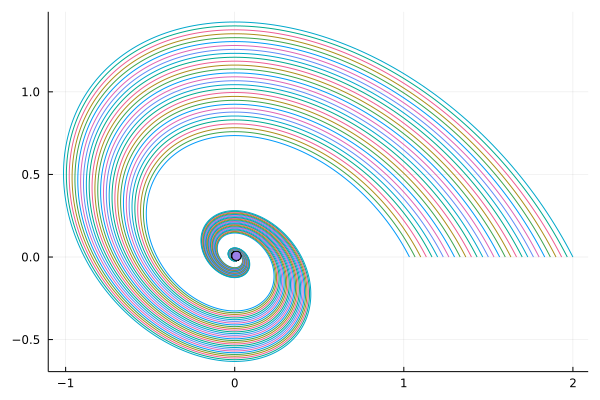

In [15]:
many_initial_point = ([1+i/30,0] for i in 1:30)

draw_ODE_solution(simpleODE1,0.01,10.,many_initial_point...)

The picture should look like a snail shell

### This ODE does not behave as it should

Let us turn to the following ODE in 2D.
$$ \begin{cases} X_1' &= 1,\\ X_2' &= \sqrt{|X_2|}. \end{cases}.$$

In [16]:
function unstableODE(x::Array{<:Real,1})
    dx1 = 1
    dx2 = sqrt(abs(x[2]))
    return vcat(dx1, dx2)
end

unstableODE (generic function with 1 method)

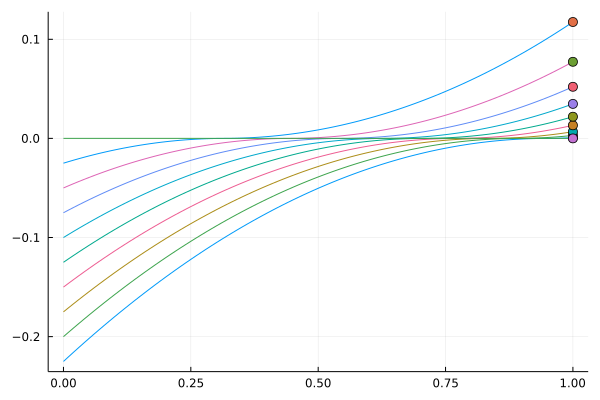

In [17]:
many_initial_point = ([0,-0.25+i/40] for i in 1:10)

draw_ODE_solution(unstableODE,0.01,1.,many_initial_point...)

**Wait a minute!!** There is one straight solution $X(t) = (t,0)$ and all the others are crossing it. Aren't solutions of ODE supposed to never cross each other? Why is this happening??? ***Please tell me.***

Answer: the reason that the straight solution $X(t) = (t,0)$ is being crossed by all of the other solutions is that $\sqrt{|X_2|}$ is not differentiable at $x = 0$. Hence, $X_2' = \sqrt{|X_2|}$ is not defined at 0. 




### The Lorentz system

A popular 3D ODE that produces pretty pictures is the Lorentz system. It is given by the formula
$$ \begin{cases}
x' &= \sigma(y-x), \\
y' &= x(\rho-z) - y, \\
z' &= xy - \beta z.
\end{cases}$$

Let us compute it for $\beta = 8/3$, $\sigma = 10$ and $\rho = 28$.

In [18]:
function lorentz(x::Array{<:Real,1})
    dx = 10*(x[2] - x[1])
    dy = x[1]*(28 - x[3]) - x[2]
    dz = x[1]*x[2] - (8/3)*x[3]
    return vcat(dx, dy, dz)
end

lorentz (generic function with 1 method)

In [19]:
function draw_3DODE_solution(ode::Function, h::Real, time::Real, x0_list::Array{<:Real,1}...)
    p = plot3d()
    iterations = Int(round(time/h))
    for x0 in x0_list
        x_list = [x0[1]]
        y_list = [x0[2]]
        z_list = [x0[3]]
        x = x0
        for i in 1:iterations
            u = RK4(x,ode,h)
            push!(x_list,u[1])
            push!(y_list,u[2])
            push!(z_list,u[3])
            x = u
        end
        plot3d!(x_list,y_list,z_list, label="")
    end
    return p
end

draw_3DODE_solution (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /Users/dimitriyl/fall2021/math212/tmp.gif
└ @ Plots /Users/dimitriyl/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/Users/dimitriyl/fall2021/math212/tmp.gif")
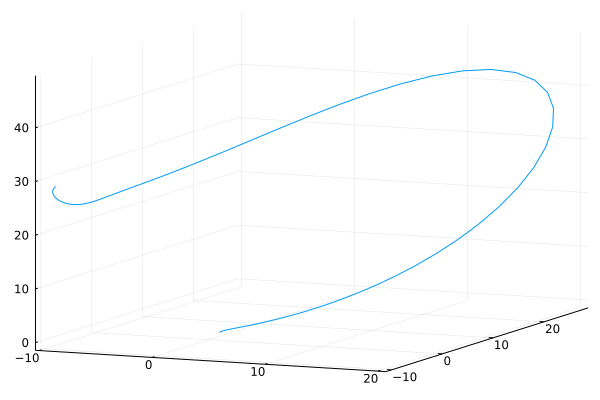

In [20]:
@gif for i in 1:100
    draw_3DODE_solution(lorentz,0.01,i,[1.,0.,0.])
end

### A bouncing ball

Let us now compute an ODE for a ball bouncing on a trampoline. Let $x(t)$ be the height of this ball, which should follow the following ODE.
$$ x'(t) = v(t), \qquad v'(t) = \begin{cases} -1 & \text{ if } x(t)>0, \\
-1 + x(t)^2 & \text{ if } x(t)<0. \end{cases} $$

In [21]:
function bouncing_ball(u::Array{<:Real,1})
    # Note that here u is a vector in R^2, corresponding to [x(t),v(t)] in the equation above
    dx = u[2]
    if u[1] > 0
        dv = -1
    else
        dv = -1 + (u[1])^2
    end
    return vcat(dx, dv)
end

bouncing_ball (generic function with 1 method)

If you wrote the function correctly, the following code should generate a pretty animation.

┌ Info: Saved animation to 
│   fn = /Users/dimitriyl/fall2021/math212/tmp.gif
└ @ Plots /Users/dimitriyl/.julia/packages/Plots/5kcBO/src/animation.jl:114


Plots.AnimatedGif("/Users/dimitriyl/fall2021/math212/tmp.gif")
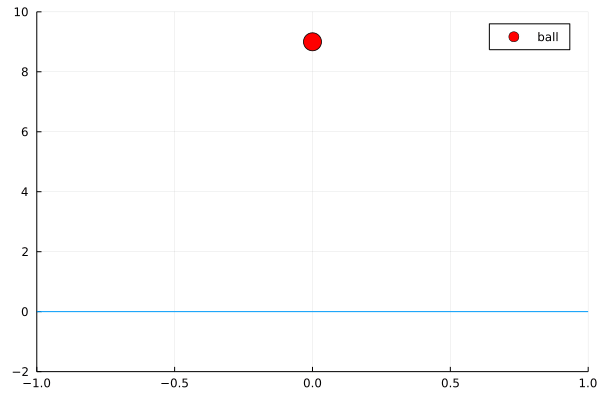

In [22]:
let x = [9.,0.] , h = 0.1
    @gif for i in 1:105
        plot(xlims=(-1,1), ylims=(-2,10))
        if x[1]>0
            plot([-1.,1.],[0.,0.],label="",xlims=(-1,1), ylims=(-2,10))
        else
            plot([-1.,0.,1.],[0.,x[1],0.],label="",xlims=(-1,1), ylims=(-2,10))
        end
        scatter!([0.],[x[1]],color=:red, markersize=10, label="ball",xlims=(-1,1), ylims=(-2,10))
        x = RK4(x,bouncing_ball,h)
    end
end